In [2]:
# prerequisite
# pip install -U imbalanced-learn

In [3]:
import matplotlib.pyplot as plt
from pipelines.DataPipeline import DataPipeline
from transformers.Preprocessing import Preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from utils.Common import Config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
RAW_DATA_PATH = "../data/raw/KSI.csv"
df = pd.read_csv(RAW_DATA_PATH)

In [5]:
# fill missing values, adding new columns, extracting useful columns
pc = Preprocessing(df, Config.binary_columns, Config.cat_attribs, Config.num_attribs, Config.label)
new_df = pc.getFrame()

In [6]:
# seperate feature and label
X = new_df[Config.cat_attribs + Config.num_attribs+ Config.binary_columns]
Y = new_df[Config.label]

In [7]:
# pass feature to pipeline and convert it to numerical data
X = DataPipeline(Config.num_attribs,Config.cat_attribs).process(X)

In [8]:
X.isna().sum().sum()

0

In [9]:
Y.value_counts().tolist()

[14246, 2201]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=Config.test_size, stratify=Y, random_state=42)

In [11]:
smote_minority = SMOTE(sampling_strategy = "minority", random_state=42)
X_train_sm, y_train_sm = smote_minority.fit_resample(X_train, y_train)


In [43]:

# Create param grid

from sklearn.model_selection import RandomizedSearchCV


param_grid = {
              'n_estimators': [100,200,400,600,1000],
              'criterion': ['gini', 'entropy'], 
              'min_samples_split':  range(5,50, 5),
              'min_samples_leaf': range(1, 15, 3),
              'max_depth': range(5, 20, 1)
              } 

clf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    scoring="accuracy",
    param_distributions=param_grid,
    cv=10,
    n_iter = 7,
    refit=True,
    verbose=3,
    random_state=42
)

best_clf = clf.fit(X_train_sm, y_train_sm)

best_clf.best_score_

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.664 total time=   0.9s
[CV 2/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.742 total time=   0.9s
[CV 3/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.875 total time=   0.9s
[CV 4/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.866 total time=   0.9s
[CV 5/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.870 total time=   0.9s
[CV 6/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.886 total time=   0.9s
[CV 7/10] END criterion=gini, max_depth=8, min_samples_leaf=13, min_samples_split=10, n_estimators=100;, score=0.862 total 

0.922400849095094

In [44]:
best_model = best_clf.best_estimator_
best_model.score(X_test,y_test)

0.8708206686930091

In [45]:
best_model.score(X_train,y_train)

0.9143421752679182

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

best_model = RandomForestClassifier(n_estimators= 400, min_samples_split=35,  min_samples_leaf= 10,  max_depth= 18,  criterion= 'gini')
best_model.fit(X_train_sm, y_train_sm)

y_train_pred = best_model.predict(X_train)
y_train_sm_pred = best_model.predict(X_train_sm)
y_test_pred = best_model.predict(X_test)

print(classification_report(y_train,y_train_pred))
print(classification_report(y_train_sm,y_train_sm_pred))
print(classification_report(y_test,y_test_pred))

print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_train_sm,y_train_sm_pred))
print(accuracy_score(y_test,y_test_pred))

print(precision_score(y_train,y_train_pred))
print(precision_score(y_train_sm,y_train_sm_pred))
print(precision_score(y_test,y_test_pred))

print(recall_score(y_train,y_train_pred))
print(recall_score(y_train_sm,y_train_sm_pred))
print(recall_score(y_test,y_test_pred))

print(f1_score(y_train,y_train_pred))
print(f1_score(y_train_sm,y_train_sm_pred))
print(f1_score(y_test,y_test_pred))

print(confusion_matrix(y_train,y_train_pred))
print(confusion_matrix(y_train_sm,y_train_sm_pred))
print(confusion_matrix(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11396
           1       0.75      0.53      0.62      1761

    accuracy                           0.91     13157
   macro avg       0.84      0.75      0.79     13157
weighted avg       0.91      0.91      0.91     13157

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11396
           1       0.97      0.92      0.94     11396

    accuracy                           0.95     22792
   macro avg       0.95      0.95      0.95     22792
weighted avg       0.95      0.95      0.95     22792

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2850
           1       0.53      0.31      0.39       440

    accuracy                           0.87      3290
   macro avg       0.72      0.63      0.66      3290
weighted avg       0.85      0.87      0.86      3290

0.9135061184160523


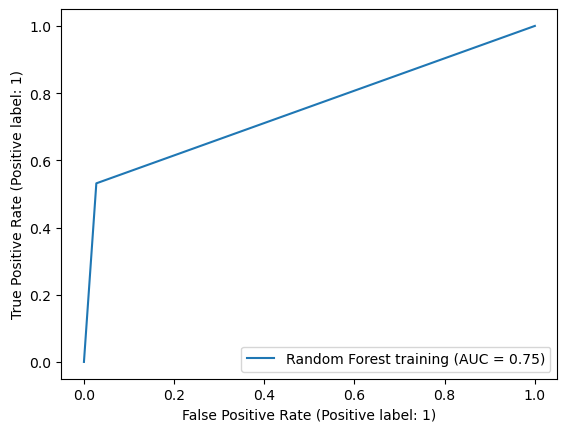

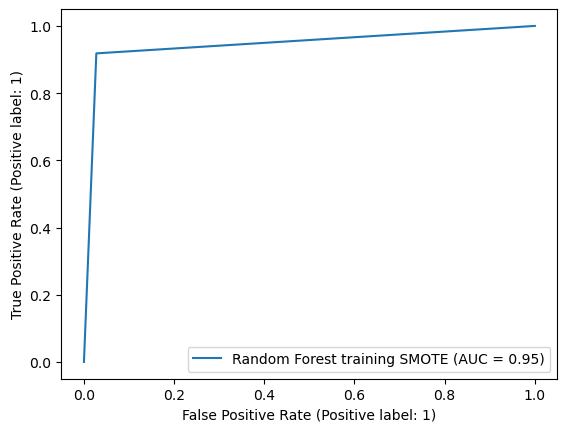

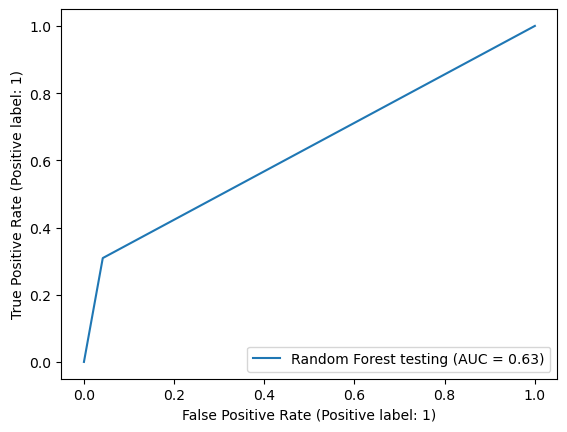

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
RocCurveDisplay.from_predictions(y_train, y_train_pred, name="Random Forest training")
RocCurveDisplay.from_predictions(y_train_sm,y_train_sm_pred, name="Random Forest training SMOTE")
RocCurveDisplay.from_predictions(y_test, y_test_pred, name="Random Forest testing")
plt.show()

In [47]:
best_clf.best_params_
# ('n_estimators': 400, 'min_samples_split': 35,  'min_samples_leaf': 10,  'max_depth': 18,  'criterion': 'gini')

{'n_estimators': 400,
 'min_samples_split': 35,
 'min_samples_leaf': 10,
 'max_depth': 18,
 'criterion': 'gini'}

In [1]:
import joblib

best_model = RandomForestClassifier(n_estimators= 400, min_samples_split=35,  min_samples_leaf= 10,  max_depth= 18,  criterion= 'gini')
best_model.fit(X_train_sm, y_train_sm)
joblib.dump(best_model,'../models/best_model_random_forest.pkl')


NameError: name 'RandomForestClassifier' is not defined